In [73]:
# importing necessary libraries for sentimental analysis
import numpy as np
import pandas as pd
from cytoolz import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

tqdm.pandas()

In [74]:
# reading data
df = pd.read_csv("./Spotify.csv", index_col=0)
df

,Review,Rating,Total_thumbsup,Reply
Time_submitted,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...
2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN


<Axes: ylabel='Frequency'>

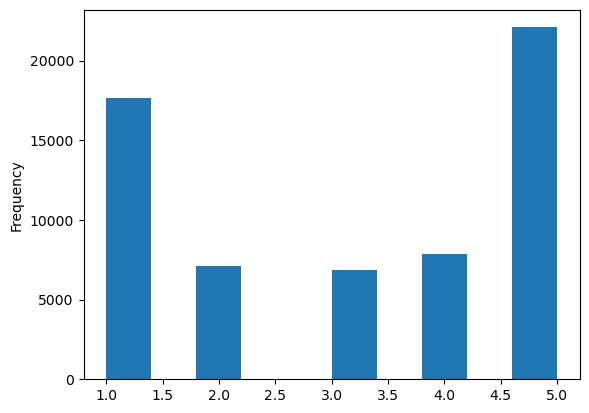

In [75]:
df["Rating"].plot(kind="hist")

In [76]:
# Drop rows with Rating = 3 as the neutral reviews would confuse the classifiers in deciding good and bad sentiments
df = df[df["Rating"] != 3]

<Axes: ylabel='Frequency'>

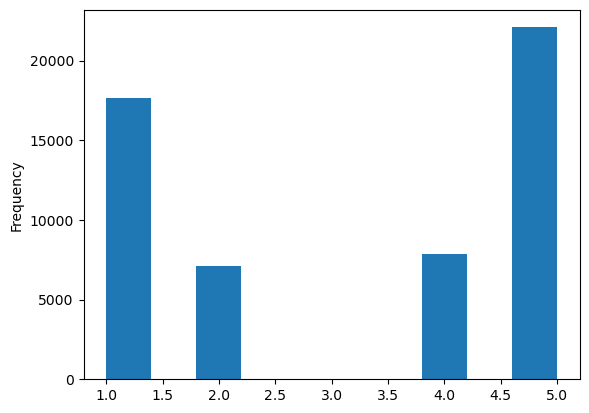

In [77]:
df["Rating"].plot(kind="hist")

In [78]:
# creating new sentiment column
df["Sentiment"] = df["Rating"].apply(lambda x: "negative" if x < 3 else "positive")

/tmp/ipykernel_897435/3663879288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentiment"] = df["Rating"].apply(lambda x: "negative" if x < 3 else "positive")


In [79]:
df.head()

,Review,Rating,Total_thumbsup,Reply,Sentiment
Time_submitted,,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,positive
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,positive
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,positive
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,negative
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,negative


In [80]:
df.groupby("Sentiment")["Rating"].value_counts()

Sentiment  Rating
negative   1         17653
           2          7118
positive   5         22095
           4          7842
Name: Rating, dtype: int64

Seems like the Reviews are well distributed with respect to sentiment

### Dummy baseline
This Dummy classifier is used to compare the performance of more advanced classification models.

In [81]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [82]:
train, test = train_test_split(
    df, test_size=0.2, stratify=df["Sentiment"], random_state=619
)

In [83]:
dummy = DummyClassifier()
dummy.fit(train["Review"], train["Sentiment"])
print(accuracy_score(test["Sentiment"], dummy.predict(test["Review"])))

0.5472491317857796


### VADER

In [84]:
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Compound scores
VADER "compound" scores are an aggregate measure of overall sentiment. VADER uses a predefined lexicon so there's no need for "training" data.

In [85]:
#creating an instance of the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


def get_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]


train["vader"] = train["Review"].progress_apply(get_sentiment)
test["vader"] = test["Review"].progress_apply(get_sentiment)

  0%|          | 0/43766 [00:00<?, ?it/s]

  0%|          | 0/10942 [00:00<?, ?it/s]

Highly positive reviews have high compound scores. Highly negative reviews have low compound scores on average, but there is a lot of variation

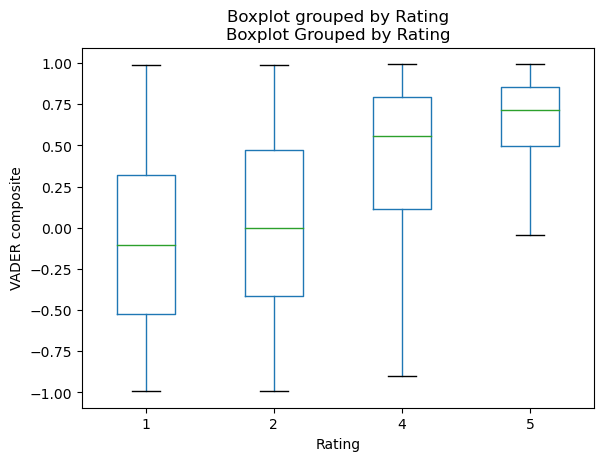

In [86]:
#Showing distribution of VADER composite scores for different ratings.
train.boxplot("vader", by="Rating", grid=False, showfliers=False)
plt.ylabel("VADER composite")
plt.title("Boxplot Grouped by Rating")
plt.show()

Can we find a cutoff value theta, where compound>theta = good review and compound<=theta = bad review? We'll find a threshold using the training data and then test it on our test data.

In [87]:
theta = np.linspace(-1.0, 1.0, 50)#NumPy Python library to create an array of 50 equally spaced values between -1.0 and 1.0, 
#inclusive. 
compound = [
    accuracy_score((train["vader"] > t), (train["Sentiment"] == "positive")) for t in theta
]

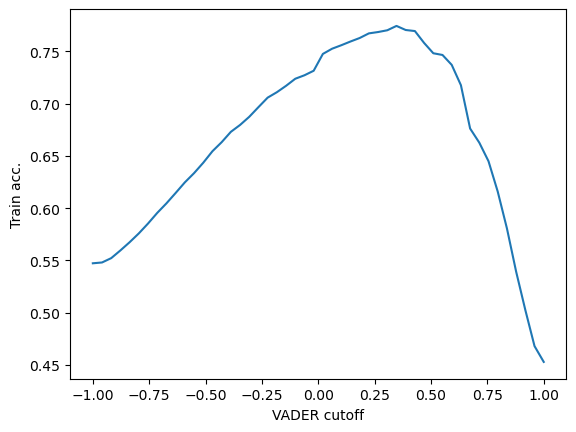

In [88]:
plt.plot(theta, compound)
plt.xlabel("VADER cutoff")
plt.ylabel("Train acc.")
plt.show()

In [89]:
theta[np.argmax(compound)]

0.346938775510204

In [90]:
thresh = _
accuracy_score((test["vader"] > thresh), (test["Sentiment"] == "positive"))

0.7807530615975141

### Parsing the input

In [91]:
import spacy
from spacy import displacy
from spacy.tokens import DocBin

nlp = spacy.load("en_core_web_lg", exclude=["ner"])

In [92]:
docs = DocBin(docs=nlp.pipe(tqdm(df['Review']), n_process=4))
docs.to_disk('parsed.docbin')

#Finally, the DocBin object is saved to disk in a file named "parsed.docbin". This allows the processed documents to be 
#easily loaded and reused in the future, without having to re-run the processing pipeline on the raw text data.

  0%|          | 0/54708 [00:00<?, ?it/s]

In [93]:
docs = DocBin().from_disk("parsed.docbin")
df["doc"] = list(docs.get_docs(nlp.vocab))

/tmp/ipykernel_897435/1520216898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["doc"] = list(docs.get_docs(nlp.vocab))


In [94]:
train, test = train_test_split(
    df, test_size=0.2, stratify=df["Sentiment"], random_state=619
)

## Syntactically augmented classification
The easiest way to add syntactic information to SGDClassifier is by augmenting the words in the text. That is, if we want to indicate that word is in the scope of negation we'll prefix the word with NOT:

In [95]:
from spacy.tokens import Token

Token.set_extension("neg", default=False, force=True)

In [96]:
def simple_negation(doc):
    for tok in doc:
        tok._.neg = False
    for tok in doc:
        if tok.dep_ == "neg":
            tok.head._.neg = True
    return doc


def add_not(tok):
    if tok._.neg:
        return "NOT:" + tok.norm_
    else:
        return tok.norm_


def tokenize_not(negator):
    def tokenize(doc):
        return [add_not(t) for t in negator(doc)]

    return tokenize

In [97]:
m1 = make_pipeline(
    CountVectorizer(
        preprocessor=identity,
        tokenizer=tokenize_not(simple_negation),
        token_pattern=None,
    ),
    TfidfTransformer(),
    SGDClassifier(random_state=1),
)
m1.fit(train["doc"], train["Sentiment"])
m1.score(test["doc"], test["Sentiment"])

0.899652714311826

In [98]:
# defining function to identify important words
def print_top_feats(M, k=0):
    V = M.named_steps["countvectorizer"].get_feature_names_out()
    coef = M.named_steps["sgdclassifier"].coef_[0]
    order = coef.argsort()
    for w1, w2 in zip(order[-k:][::-1], order[:k]):
        print(f"{V[w1]:20s} {coef[w1]:7.3f} | {V[w2]:20s} {coef[w2]:7.3f}")

The most important features (words) that contribute positively or negatively to the classification model's decision-making process, based on their corresponding coefficients by SGD classifier with prefixing NOT are as follows

In [99]:
print_top_feats(m1, 50)

love                   5.879 | not                   -4.109
great                  5.303 | worst                 -3.589
best                   4.609 | misinformation        -2.729
good                   3.956 | horrible              -2.462
amazing                3.927 | buggy                 -2.360
easy                   3.041 | worse                 -2.309
awesome                2.839 | trash                 -2.276
nice                   2.692 | terrible              -2.243
thank                  2.532 | useless               -2.216
excellent              2.446 | sucks                 -2.192
perfect                2.306 | fix                   -2.162
enjoy                  2.196 | bad                   -2.111
wish                   2.013 | hate                  -2.068
favorite               1.912 | poor                  -1.951
but                    1.912 | now                   -1.937
wonderful              1.846 | constantly            -1.933
music                  1.823 | frustrati

Next step: once we've identified negated words, we'll spread the negative marker onto dependent words that come to the right of the negate word. Not all words to the right, though. Just ones that are dependents of the negated word.

In [100]:
def negify(tok):
    tok._.neg = True
    for child in tok.children:
        negify(child)


def negate_comps(doc):
    for tok in doc:
        tok._.neg = False
    for tok in doc:
        if tok.dep_ == "neg":
            tok.head._.neg = True
            for right_tok in tok.head.rights:
                if right_tok.dep_ in ["acomp", "advmod", "dobj", "prep", "xcomp"]:
                    negify(right_tok)
    return doc

In [101]:
m2 = make_pipeline(
    CountVectorizer(
        preprocessor=identity, tokenizer=tokenize_not(negate_comps), token_pattern=None
    ),
    TfidfTransformer(),
    SGDClassifier(alpha=1e-4, random_state=1),
)
m2.fit(train["doc"], train["Sentiment"])
m2.score(test["doc"], test["Sentiment"])

0.9000182781941144

The most important features (words) that contribute positively or negatively to the classification model's decision-making process, based on their corresponding coefficients by SGD classifier with spreading the negative marker onto dependent words are as follows 

In [102]:
print_top_feats(m2, 50)

love                   5.831 | not                   -3.831
great                  5.421 | worst                 -3.596
best                   4.643 | misinformation        -2.656
good                   4.142 | horrible              -2.375
amazing                3.894 | bad                   -2.365
easy                   3.007 | worse                 -2.322
awesome                2.881 | buggy                 -2.312
nice                   2.763 | trash                 -2.303
thank                  2.589 | sucks                 -2.269
excellent              2.467 | terrible              -2.254
perfect                2.380 | fix                   -2.207
enjoy                  2.126 | hate                  -2.082
worth                  2.100 | useless               -2.049
favorite               2.089 | poor                  -2.001
wish                   2.008 | now                   -1.986
music                  2.005 | frustrating           -1.930
wonderful              1.974 | constantl

Next, we'll combine heads with their modifiers

In [103]:
def mod_tokenizer(doc):
    doc = negate_comps(doc)
    toks = [add_not(tok) for tok in doc]
    toks = toks + [
        add_not(t.head) + "_" + add_not(t) for t in doc if t.dep_ in ["amod", "advmod"]
    ]
    return toks

In [104]:
m3 = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=mod_tokenizer, token_pattern=None),
    TfidfTransformer(),
    SGDClassifier(),
)
m3.fit(train["doc"], train["Sentiment"])
m3.score(test["doc"], test["Sentiment"])

0.9023944434289892

The most important features (words) that contribute positively or negatively to the classification model's decision-making process, based on their corresponding coefficients by SGD classifier combine heads with their modifiers are as follows

In [105]:
print_top_feats(m3, 50)

love                   6.218 | not                   -4.170
great                  5.202 | worst                 -3.291
best                   4.516 | misinformation        -2.568
good                   3.950 | horrible              -2.463
amazing                3.930 | worse                 -2.452
easy                   3.225 | bad                   -2.389
awesome                2.996 | terrible              -2.322
thank                  2.631 | sucks                 -2.312
nice                   2.455 | now                   -2.297
excellent              2.385 | fix                   -2.254
perfect                2.370 | buggy                 -2.232
music                  2.325 | trash                 -2.198
but                    2.188 | constantly            -2.058
enjoy                  2.163 | useless               -2.039
worth                  2.050 | hate                  -2.007
favorite               2.049 | crashes               -1.998
thanks                 1.997 | keeps    

## Conclusion:
Based on the results of the sentiment analysis project on Spotify app reviews, different approaches were applied to enhance the accuracy of the SGD classifier. Here's the conclusion based on the accuracy scores obtained:

Using the "NOT" prefix for negation scope achieved an accuracy score of 0.8997. This approach accounted for negations by adding the "NOT" prefix to words within the scope of negation. Although it improved the accuracy, there is still room for further enhancement.

Employing the spread of the negative marker onto dependent words to the right of the negation word resulted in an accuracy score of 0.9000. This approach expanded the negative influence of a negation word to its dependent words on the right. It slightly improved accuracy compared to the "NOT" prefix approach.

Combining heads with their modifiers yielded the highest accuracy score of 0.9027. This approach involved considering the relationship between the main word (head) and its modifying words. By combining them, it captured more nuanced sentiment expressions, resulting in a higher accuracy score.

Based on these results, it can be concluded that combining heads with their modifiers was the most effective approach for sentiment analysis on Spotify app reviews. It outperformed the other two approaches and achieved the highest accuracy score. This suggests that considering the relationship between words and capturing their modifying context can lead to more accurate sentiment analysis results.

However, it is worth noting that even with the highest accuracy achieved, there is still room for improvement. Further exploration of different techniques, feature engineering, or the use of more advanced models may help enhance the sentiment analysis accuracy even further in future iterations of the project.